# Landfall rainfall

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [10]:
from pathlib import Path

import pandas as pd

from src.datasources import codab
from src.constants import *

In [31]:
load_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed_adm1_v7.csv"
)
landfall_df = pd.read_csv(load_path)

In [32]:
[x for x in landfall_df.columns]

['ISO_TIME',
 'SID',
 'SEASON',
 'NUMBER',
 'BASIN',
 'SUBBASIN',
 'NAME',
 'NATURE',
 'LAT',
 'LON',
 'WMO_WIND',
 'WMO_PRES',
 'WMO_AGENCY',
 'TRACK_TYPE',
 'DIST2LAND',
 'LANDFALL',
 'IFLAG',
 'USA_AGENCY',
 'USA_ATCFID',
 'USA_LAT',
 'USA_LON',
 'USA_RECORD',
 'USA_STATUS',
 'USA_WIND',
 'USA_PRES',
 'USA_SSHS',
 'USA_R34_NE',
 'USA_R34_SE',
 'USA_R34_SW',
 'USA_R34_NW',
 'USA_R50_NE',
 'USA_R50_SE',
 'USA_R50_SW',
 'USA_R50_NW',
 'USA_R64_NE',
 'USA_R64_SE',
 'USA_R64_SW',
 'USA_R64_NW',
 'USA_POCI',
 'USA_ROCI',
 'USA_RMW',
 'USA_EYE',
 'TOK_LAT',
 'TOK_LON',
 'TOK_GRADE',
 'TOK_WIND',
 'TOK_PRES',
 'TOK_R50_DR',
 'TOK_R50_L',
 'TOK_R50_S',
 'TOK_R30_DR',
 'TOK_R30_L',
 'TOK_R30_S',
 'TOK_LAND',
 'CMA_LAT',
 'CMA_LON',
 'CMA_CAT',
 'CMA_WIND',
 'CMA_PRES',
 'HKO_LAT',
 'HKO_LON',
 'HKO_CAT',
 'HKO_WIND',
 'HKO_PRES',
 'KMA_LAT',
 'KMA_LON',
 'KMA_CAT',
 'KMA_WIND',
 'KMA_PRES',
 'KMA_R50_DR',
 'KMA_R50_L',
 'KMA_R50_S',
 'KMA_R30_DR',
 'KMA_R30_L',
 'KMA_R30_S',
 'NEW_LAT',
 'NEW

In [35]:
cols = [
    "SID",
    "SEASON",
    "NAME",
    "USA_WIND",
    "LAT",
    "LON",
    "year",
    "month",
    "day",
]

In [36]:
landfall_df = landfall_df[cols]

In [38]:
date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)

In [39]:
landfall_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day
0,1999357S08076,2000,ASTRIDE,25.000000,-13.633333,40.466667,2000,1,3
1,2000032S11116,2000,ELINE:LEONE,109.000000,-20.550000,34.750000,2000,2,22
2,2000058S14063,2000,GLORIA,25.000000,-23.983333,35.433333,2000,3,9
3,2000083S17102,2000,HUDAH,80.000000,-17.200000,38.300000,2000,4,8
4,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26
5,2003056S21042,2003,JAPHET,86.500000,-21.800000,35.250000,2003,3,2
6,2007043S11071,2007,FAVIO,93.333333,-21.900000,35.300000,2007,2,22
7,2008062S10064,2008,JOKWE,94.166667,-15.983333,40.133333,2008,3,8
8,2009082S16039,2009,IZILDA,15.000000,-20.200000,34.700000,2009,3,29
9,2012010S24049,2012,DANDO,NaN,-24.800000,34.500000,2012,1,16


In [41]:
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)

In [42]:
landfall_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day,landfall_date
0,1999357S08076,2000,ASTRIDE,25.000000,-13.633333,40.466667,2000,1,3,2000-01-03
1,2000032S11116,2000,ELINE:LEONE,109.000000,-20.550000,34.750000,2000,2,22,2000-02-22
2,2000058S14063,2000,GLORIA,25.000000,-23.983333,35.433333,2000,3,9,2000-03-09
3,2000083S17102,2000,HUDAH,80.000000,-17.200000,38.300000,2000,4,8,2000-04-08
4,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26
5,2003056S21042,2003,JAPHET,86.500000,-21.800000,35.250000,2003,3,2,2003-03-02
6,2007043S11071,2007,FAVIO,93.333333,-21.900000,35.300000,2007,2,22,2007-02-22
7,2008062S10064,2008,JOKWE,94.166667,-15.983333,40.133333,2008,3,8,2008-03-08
8,2009082S16039,2009,IZILDA,15.000000,-20.200000,34.700000,2009,3,29,2009-03-29
9,2012010S24049,2012,DANDO,NaN,-24.800000,34.500000,2012,1,16,2012-01-16


In [6]:
adm1 = codab.load_codab(aoi_only=True)

<Axes: >

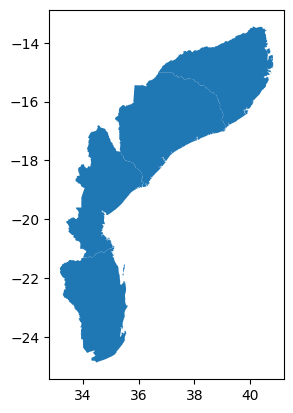

In [7]:
adm1.plot()